In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir('/projects/cft_vlm/finetune')

In [2]:
from transformers import AutoProcessor, Qwen2_5_VLForConditionalGeneration
import torch


processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct", use_fast=True)
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
  "Qwen/Qwen2.5-VL-3B-Instruct",
  torch_dtype=torch.bfloat16,
  device_map='auto',
  attn_implementation='flash_attention_2'
)

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
processor.tokenizer.__dict__

{'add_prefix_space': False,
 '_tokenizer': Tokenizer(version="1.0", truncation=None, padding=None, added_tokens=[{"id":151643, "content":"<|endoftext|>", "single_word":False, "lstrip":False, "rstrip":False, "normalized":False, "special":True}, {"id":151644, "content":"<|im_start|>", "single_word":False, "lstrip":False, "rstrip":False, "normalized":False, "special":True}, {"id":151645, "content":"<|im_end|>", "single_word":False, "lstrip":False, "rstrip":False, "normalized":False, "special":True}, {"id":151646, "content":"<|object_ref_start|>", "single_word":False, "lstrip":False, "rstrip":False, "normalized":False, "special":True}, {"id":151647, "content":"<|object_ref_end|>", "single_word":False, "lstrip":False, "rstrip":False, "normalized":False, "special":True}, {"id":151648, "content":"<|box_start|>", "single_word":False, "lstrip":False, "rstrip":False, "normalized":False, "special":True}, {"id":151649, "content":"<|box_end|>", "single_word":False, "lstrip":False, "rstrip":False, "

In [7]:
from qwenvl.argument import ProcessingArguments
from qwenvl.data.utils import make_model_input
from pathlib import Path

vid_dir = Path('/projects/cft_vlm/datasets/openbiomedvid/data/vid_segments')

conversation = [
  {"role": "user",
   "content": [
    {
      'type': 'text',
      'text': "Describe the video.\n"
    },
    {
      'type': 'video',
      'video': str(vid_dir / '00cD-55fnaw_2590_3016.mp4')
    }
    ]},
  {"role": "assistant",
   "content": [
    {
      'type': 'text',
      'text': "This video describes.\n"
    },
    {
      'type': 'video',
      'video': str(vid_dir / '01KY3GQKBzg_14_158.mp4')
    }
    ]},
]
proc_args = ProcessingArguments()

text = processor.apply_chat_template(conversation, add_generation_prompt=True, tokenize=False, add_vision_id=True)
print(text)
inputs = make_model_input(conversation, processor, proc_args, for_training=False, use_cft=True)

<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
Describe the video.
Video 1: <|vision_start|><|video_pad|><|vision_end|><|im_end|>
<|im_start|>assistant
This video describes.
Video 2: <|vision_start|><|video_pad|><|vision_end|><|im_end|>
<|im_start|>assistant



Unused or unrecognized kwargs: return_tensors, fps.


Describe the video.
<|vision_start|><|video_pad|><|vision_end|>This video describes.
<|vision_start|><|video_pad|><|vision_end|>


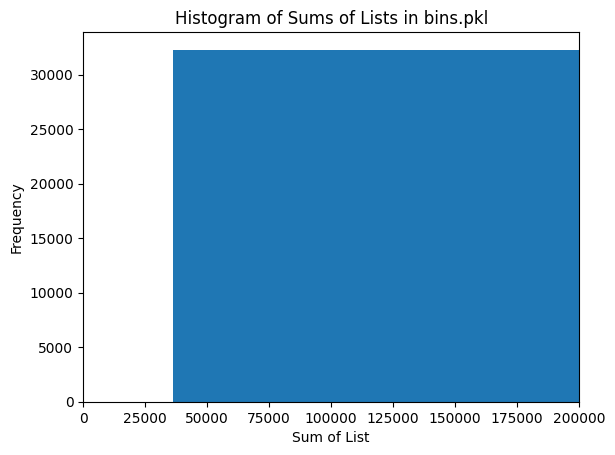

In [5]:
import pickle

import matplotlib.pyplot as plt

# Load the list of lists of integers
with open('/projects/cft_vlm/datasets/open_pmc/data/dataset/bins.pkl', 'rb') as f:
  bins = pickle.load(f)

# Compute the sum of each list
sums = [sum(lst) for lst in bins]

# Plot histogram
plt.hist(sums, bins=100)
plt.xlabel('Sum of List')
plt.xlim([0, 200000])  # Adjust x-axis limits as needed
plt.ylabel('Frequency')
plt.title('Histogram of Sums of Lists in bins.pkl')
plt.show()

In [25]:
with torch.inference_mode():
  gen_config = model.generation_config
  gen_config.max_new_tokens = 32
  
  outputs = model.generate(
    **inputs,
    generation_config=gen_config,
  )

processor.batch_decode(outputs, skip_special_tokens=True)

/fs01/projects/cft_vlm/.venv/lib/python3.10/site-packages/transformers/generation/utils.py:2479: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


['system\nYou are a helpful assistant.\nuser\nDescribe the video.\nVideo 1: \nuser\nDescribe the video.\nVideo 2: \nassistant\nThe video begins with a title card that reads "Nick Mamalis, M.D." and "Professor - Department of Ophthalmology/Visual Sciences." The card']

In [15]:
inputs

{'input_ids': tensor([[151644,   8948,    198,  ..., 151653, 151645,    198]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]]), 'pixel_values_videos': tensor([[ 1.8865,  1.8865,  1.8865,  ...,  2.0890,  2.0890,  2.0890],
        [ 1.8865,  1.8865,  1.8865,  ...,  2.0890,  2.0890,  2.0890],
        [ 1.8281,  1.8281,  1.8281,  ...,  2.0464,  2.0464,  2.0464],
        ...,
        [-1.6171, -1.6171, -1.6171,  ..., -1.2385, -1.2385, -1.2385],
        [-1.5587, -1.5587, -1.5733,  ..., -1.2385, -1.2385, -1.2385],
        [-1.6609, -1.6609, -1.6609,  ..., -1.2527, -1.2527, -1.2527]]), 'video_grid_thw': tensor([[15, 26, 46],
        [15, 26, 46]]), 'second_per_grid_ts': tensor([28.3667,  9.5667]), 'labels': tensor([[-100, -100, -100,  ..., -100, -100, -100]])}

In [23]:
# ...existing code...

import torch

from transformers.modeling_outputs import BaseModelOutputWithPast

def decode_tokens(tokenizer, tensor):
  if tensor is None:
    return None
  if tensor.ndim > 1:
    tensor = tensor[0]
  return tokenizer.decode(tensor.tolist(), skip_special_tokens=True)


# Prepare storage for hooks
record = {}

def get_output_hook(name):
  def hook(module, input, output):
    if isinstance(output, BaseModelOutputWithPast):
      output = output['last_hidden_state']
      
    record[f"{name}_output"] = output.detach().cpu()
  return hook


# Attach hooks
lang_hook = model.language_model.register_forward_hook(
    get_output_hook("language_model")
)
vis_hook = model.visual.register_forward_hook(
    get_output_hook("visual")
)

# Run forward pass
try:
  with torch.no_grad():
    outputs = model(**inputs)
except Exception as e:
  raise e
finally:
  # Remove hooks
  lang_hook.remove()
  vis_hook.remove()

# Get logits and decode output tokens
logits = outputs.logits
output_ids = logits.argmax(-1)
decoded_output = decode_tokens(processor.tokenizer, output_ids)

In [11]:
outputs['logits'].shape

torch.Size([1, 47, 151936])

In [33]:
image_pad_token = processor.image_token_id
img_token_locs = torch.where(inputs['input_ids'] == image_pad_token)
img_token_locs = (img_token_locs[0][:-1], img_token_locs[1][:-1])

In [37]:
# Get the image tokens from the inputs
img_predict = record['language_model_output'][img_token_locs]
img_targets = record['visual_output'][1:]

In [39]:
torch.nn.functional.cosine_similarity(
    img_predict, img_targets, dim=-1
).mean().item()

0.06591796875

In [ ]:
token_predict = record['language_model_output']